In [1]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from functions import util

import warnings
warnings.filterwarnings("ignore")

In [2]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1048724
2024-09-23 21:36:19,795 WARNING: using legacy validation callback
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
air_quality_fg = fs.get_feature_group(
    name = "air_quality",
    version = 1
)

weather_fg = fs.get_feature_group(
    name = "weather",
    version = 1,
)

In [4]:
selected_features = air_quality_fg.select(['pm25']).join(weather_fg.select_all(), on = ['city'])

In [5]:
selected_features

In [6]:
selected_features.show(n = 10)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.61s) 


,pm25,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,158.0,2021-02-14 00:00:00+00:00,25.401079,0.0,11.183201,75.999123,abuja
1,160.0,2021-02-15 00:00:00+00:00,25.907333,0.0,15.281989,40.532776,abuja
2,93.0,2021-02-16 00:00:00+00:00,26.217749,0.0,20.268990,46.492268,abuja
3,124.0,2021-02-17 00:00:00+00:00,24.348997,0.0,24.464113,46.088535,abuja
4,209.0,2021-02-18 00:00:00+00:00,21.411499,0.0,21.129883,38.741505,abuja
5,269.0,2021-02-19 00:00:00+00:00,20.896915,0.0,17.566378,34.418434,abuja
6,265.0,2021-02-20 00:00:00+00:00,21.524000,0.0,12.904882,30.343174,abuja
7,219.0,2021-02-21 00:00:00+00:00,23.038584,0.0,13.104198,27.099285,abuja
8,184.0,2021-02-22 00:00:00+00:00,23.380249,0.0,13.551501,33.641457,abuja
9,166.0,2021-02-23 00:00:00+00:00,23.944832,0.0,13.755579,32.390522,abuja


In [7]:
feature_view = fs.get_or_create_feature_view(
    name = 'air_quality_fv', 
    description = 'Feature view for air quality prediction',
    version = 1, 
    labels = ['pm25'], 
    query = selected_features, 
)

In [8]:
start_date_test_data = "2024-03-01"
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [9]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.45s) 


In [10]:
train_features = X_train.drop(["date", "city"], axis = 1)
test_features = X_test.drop(["date", "city"], axis = 1)

In [11]:
train_features

,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,25.401079,0.0,11.183201,75.999123
1,25.907333,0.0,15.281989,40.532776
2,26.217749,0.0,20.268990,46.492268
3,24.348997,0.0,24.464113,46.088535
4,21.411499,0.0,21.129883,38.741505
...,...,...,...,...
1039,27.876083,0.0,12.069400,26.706001
1040,27.534416,0.0,12.620554,59.723068
1041,27.328165,0.0,9.826088,112.883598
1042,29.182333,0.0,11.808878,248.364304


In [12]:
xgb_regressor = XGBRegressor()

xgb_regressor.fit(train_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
y_pred = xgb_regressor.predict(test_features)

mse = mean_squared_error(y_test.iloc[:, 0], y_pred)
print("Mean Squared Error: ", mse)

r2 = r2_score(y_test.iloc[:, 0], y_pred)
print("R2 Score: ", r2)

Mean Squared Error:  2781.290583887002
R2 Score:  -5.88221632763831


In [14]:
y_test

,pm25
1044,101.0
1045,108.0
1046,92.0
1047,96.0
1048,97.0
...,...
1216,41.0
1217,86.0
1218,54.0
1219,28.0


In [15]:
df = y_test
df["predicted_pm25"] = y_pred

In [16]:
df["date"] = X_test["date"]
df = df.sort_values(by = ["date"])
df.head(5)

,pm25,predicted_pm25,date
1044,101.0,130.457733,2024-03-01 00:00:00+00:00
1045,108.0,154.998627,2024-03-02 00:00:00+00:00
1046,92.0,155.683304,2024-03-03 00:00:00+00:00
1047,96.0,178.564529,2024-03-04 00:00:00+00:00
1048,97.0,140.150101,2024-03-05 00:00:00+00:00


In [17]:
model_dir = "./air_quality_model"

if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = "./images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

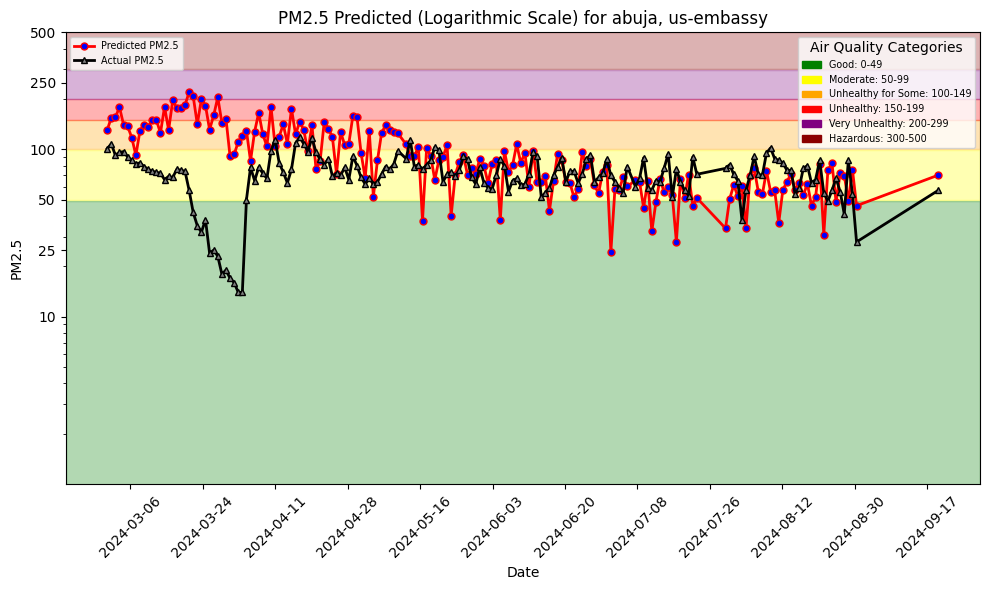

In [18]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast("abuja", "us-embassy", df, file_path, hindcast=True)
plt.show()

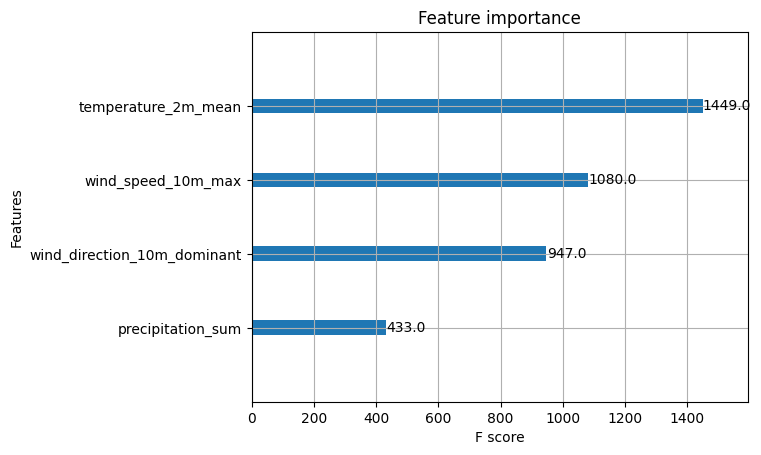

In [19]:
plot_importance(xgb_regressor, max_num_features=4)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

In [20]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [21]:
xgb_regressor.save_model(model_dir + "/model.json")

In [22]:
model_dir

'./air_quality_model'

In [23]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [24]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Air Quality (PM2.5) predictor",
)

Connected. Call `.close()` to terminate connection gracefully.


In [25]:
model_dir = "./air_quality_model"

In [26]:
aq_model.get_url()

'https://c.app.hopsworks.ai:443/p/1048724/models/air_quality_xgboost_model/None'

In [45]:
model_dir = "air_quality_model"

In [46]:
# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/447994 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/105 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/682 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1048724/models/air_quality_xgboost_model/1


Model(name: 'air_quality_xgboost_model', version: 1)